In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\peng\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (

In [2]:
# make up data
x_data = np.linspace(-7 , 10 , 2500).reshape([-1 , 1])
np.random.shuffle(x_data)
noise = np.random.normal(0 , 5 , x_data.shape)
y_data = np.square(x_data) - 5 + noise

In [3]:
def dense_layer(inputs , in_size , out_size , activaction_function = None):
    # weights and biases 
    Weights = tf.Variable(tf.truncated_normal([in_size , out_size] , mean = 0. , stddev = 0.0001) , name = 'weight')
    biases = tf.Variable(tf.zeros([1 , out_size]) + 0.0001 , name = 'bias')

    # fully connected product
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases)
    
    if activaction_function is not None: output = activaction_function(Wx_plus_b)
    else: output = Wx_plus_b
  
    return output

def highway_layer(inputs , in_size , out_size):
    with tf.variable_scope('transform_gate'): 
        # fully connected product for transform
        transform_output = dense_layer(inputs , in_size , out_size , tf.nn.relu)
 
    with tf.variable_scope('copy_gate'):  
        # fully connected product for copy 
        # 用tf.nn.sigmoid讓Wx_plus_b_c的每個元素在0~1的範圍中
        copy_coef = dense_layer(inputs , in_size , out_size , tf.nn.sigmoid)
        
    with tf.variable_scope('output_gate'):
        final_output = tf.multiply(copy_coef , inputs) + tf.multiply(1 - copy_coef , transform_output)
               
    return final_output

In [4]:
xs = tf.placeholder(tf.float32 , [None , 1] , name = 'xs')  # [num_samples , num_features]
ys = tf.placeholder(tf.float32 , [None , 1] , name = 'ys')

In [5]:
# build input layer
input_ = []
N_HIDDEN_UNITS = 30
with tf.variable_scope('input_layer'): 
    input_layer = dense_layer(xs , xs.shape[1].value , N_HIDDEN_UNITS , activaction_function = tf.nn.relu)
input_.append(input_layer)
           
# build hidden layers & highway layers
for layer in range(0 , 50):
    with tf.variable_scope('hidden_layer' + str(layer + 1)): 
        L_act = highway_layer(input_[layer] , input_[layer].shape[1].value , N_HIDDEN_UNITS)  
    input_.append(L_act)    

# build output layer
with tf.variable_scope('output_layer'):  
    prediction = dense_layer(input_[-1] , input_[-1].shape[1].value , 1 , activaction_function = None)
    
loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction) , reduction_indices = [1]) , name = 'loss')
train_op = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

def minibatch_index(minibatch_num , data):
    step = (int(len(data) / minibatch_num) + 1) * minibatch_num
    temp = []
    index = []
    j = 0
    for ii in range(0 , step):
        j = j + 1
        if j > len(data):
            j = j - (len(data))   
        temp.append(j)  
        if len(temp) == minibatch_num:
            index.append(temp)
            temp = []
    index = list(np.array(index) - 1) 
    return index
index = minibatch_index(minibatch_num = 100 , data = x_data)

train_loss_his = []
epochs = 200
for epoch_i in range(0 , epochs):
    for batch_i in range(0 , len(index)):
        # train on batch
        _ , train_loss = sess.run([train_op , loss] , 
                                  feed_dict = {xs : x_data[index[batch_i]] , ys : y_data[index[batch_i]]})       
    # record cost
    train_loss_his.append(train_loss)
    
    if epoch_i % 10 == 0:
        print('epoch : {} , train_loss : {:.2f}\n'.format(epoch_i , train_loss))

epoch : 0 , train_loss : 927.18

epoch : 10 , train_loss : 607.08

epoch : 20 , train_loss : 32.40

epoch : 30 , train_loss : 25.17

epoch : 40 , train_loss : 24.78

epoch : 50 , train_loss : 24.53

epoch : 60 , train_loss : 24.46

epoch : 70 , train_loss : 24.44

epoch : 80 , train_loss : 24.45

epoch : 90 , train_loss : 24.46

epoch : 100 , train_loss : 24.47

epoch : 110 , train_loss : 24.48

epoch : 120 , train_loss : 24.49

epoch : 130 , train_loss : 24.51

epoch : 140 , train_loss : 24.53

epoch : 150 , train_loss : 24.55

epoch : 160 , train_loss : 24.56

epoch : 170 , train_loss : 24.58

epoch : 180 , train_loss : 24.59

epoch : 190 , train_loss : 24.61



Text(0, 0.5, 'loss')

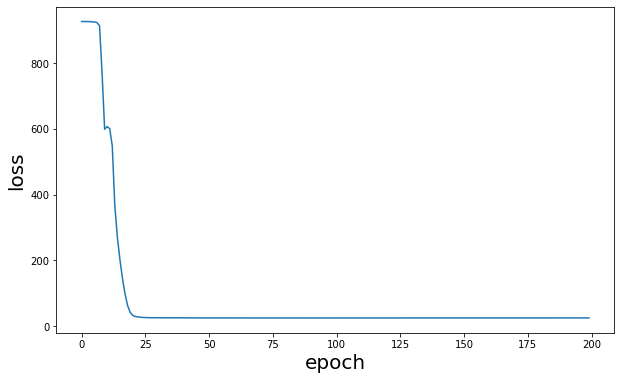

In [7]:
# plot cost curve
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
ax.plot(np.arange(len(train_loss_his)) , np.array(train_loss_his)) 
ax.set_xlabel('epoch' , fontsize = 20)
ax.set_ylabel('loss' , fontsize = 20)

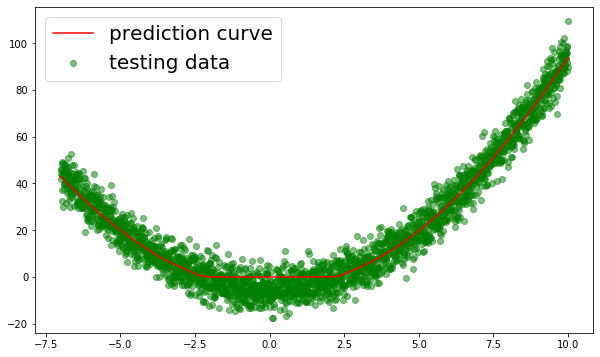

In [8]:
# plot prediction curve
fig , ax = plt.subplots(1 , 1 , figsize = (10 , 6))
x_test = np.linspace(-7 , 10 , 2500).reshape([-1 , 1])
y_test = np.square(x_test) - 5 + np.random.normal(0 , 5 , x_data.shape)
ax.scatter(x_test , y_test , c = 'g' , alpha = 0.5 , label = 'testing data')

pred = sess.run(prediction , feed_dict = {xs : x_test , ys : y_test})
ax.plot(x_test , pred , c = 'r' , label = 'prediction curve')
ax.legend(fontsize = 20)